# Empirical Labeled Ambient LDA for ambient RNA removal (Ambien't (C) )
Used pieces from JoeZJH, https://github.com/JoeZJH/Labeled-LDA-Python

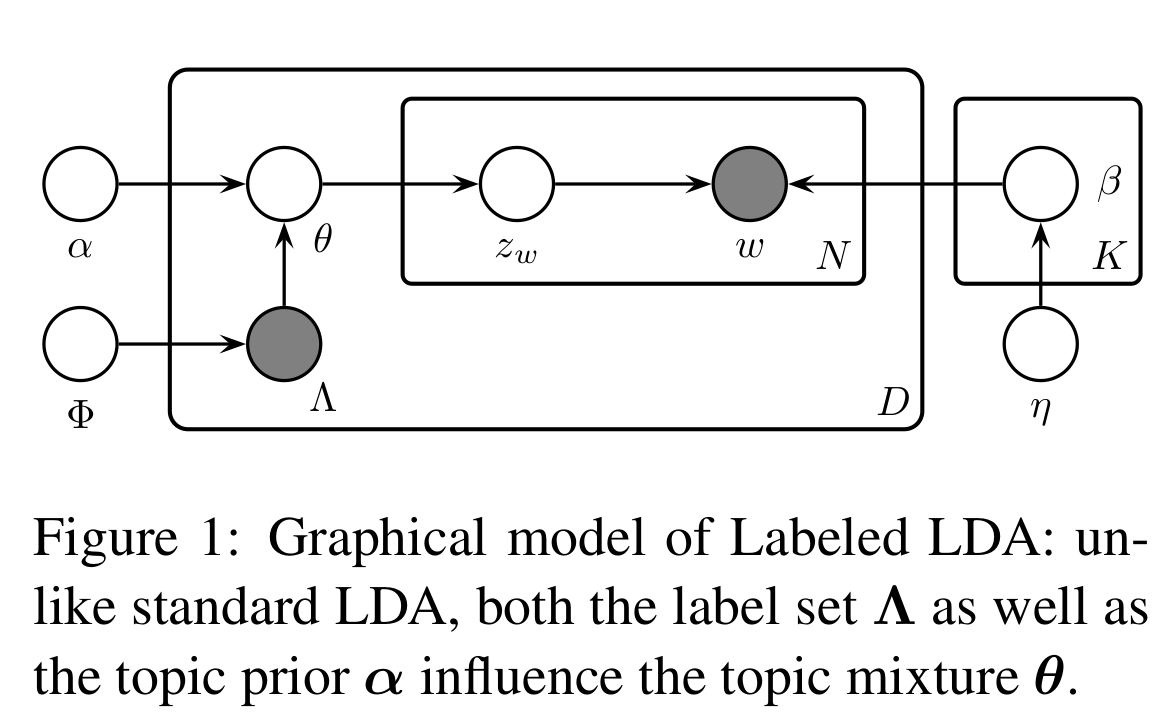

The collapsed Gibbs transition likelihood function appears below, without the term for the the distribution of ambient counts
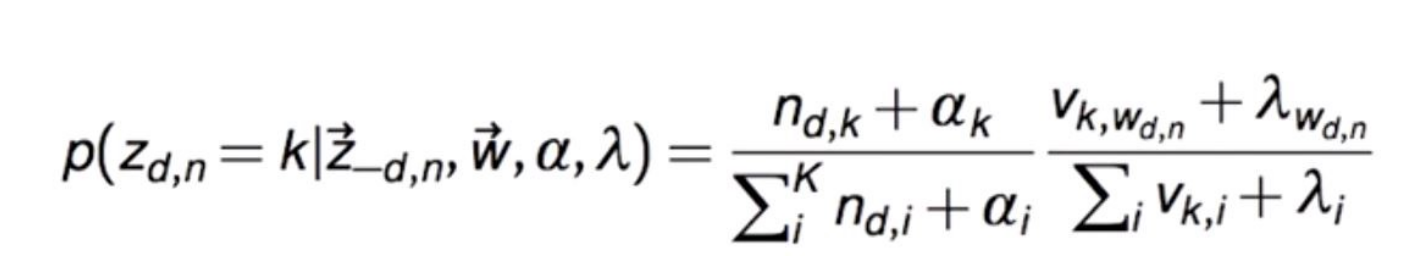

In [1]:
import os
import importlib.util
spec = importlib.util.spec_from_file_location("labeled_lda", os.path.expanduser("/home/mt/code/utils/Labeled-LDA-Python/model/labeled_lda.py"))
labeledLDA = importlib.util.module_from_spec(spec)
spec.loader.exec_module(labeledLDA)
import matplotlib
import scanpy
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
matplotlib.use('TkAgg') # plotting backend compatible with screen
import logging as logg
import os
import scipy
import sklearn
import seaborn
from collections import Counter
%matplotlib inline

Plate model of dependencies

## Load An Example Dataset and generate model

In [2]:
import scanpy.api as sc
import pandas as pd
adata = sc.read_10x_mtx('/home/mt/Downloads/E40_motor_Out/outs/raw_gene_bc_matrices/refdata-celranger-mmul8-toplevel/',cache=True)
bcs=list(pd.read_csv('/home/mt/Downloads/E40_motor_Out/outs/filtered_gene_bc_matrices/refdata-celranger-mmul8-toplevel/barcodes.tsv').iloc[:,0])
#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
adata.var_names_make_unique()
#sc.pp.filter_genes(adata, min_cells=50,inplace=True)
#sc.pp.filter_cells(adata,min_counts=5,inplace=True)
#sc.pp.filter_genes(adata, min_cells=50,inplace=True)
#adata._inplace_subset_obs(np.random.choice(adata.obs.index,30000,replace=False))
#adata._inplace_subset_var(np.random.choice(adata.var.index,5000,replace=False))
sc.pp.filter_cells(adata,min_counts=5,inplace=True)
sc.pp.filter_genes(adata, min_cells=50,inplace=True)
ambient_counts=np.log10(adata[[x not in bcs for x in adata.obs.index] ,:].obs.n_counts)


In [3]:
adata

AnnData object with n_obs × n_vars = 114082 × 10096 
    obs: 'n_counts'
    var: 'gene_ids', 'n_cells'

In [4]:
from scipy.stats import gaussian_kde
cell_inds=np.where([x in bcs for x in adata.obs.index])[0]
junk_inds=np.where([x not in bcs for x in adata.obs.index])[0]
ambient_pdf=gaussian_kde(ambient_counts)
adata._inplace_subset_var(adata[junk_inds,:].X.sum(axis=0).A1>5) 
X=adata.X
W=X.shape[1]
betaAmbient = adata[junk_inds,:].X.sum(axis=0)/adata[junk_inds,:].X.sum(axis=1).sum()

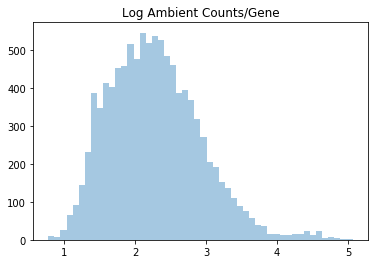

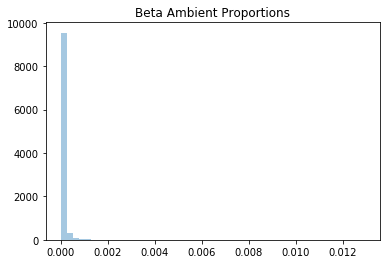

In [5]:
#print(sorted(adata[junk_inds,:].X.sum(axis=0).A1))
seaborn.distplot(np.log10(adata[junk_inds,:].X.sum(axis=0)),kde=False).set_title('Log Ambient Counts/Gene')
plt.show()
seaborn.distplot(betaAmbient,kde=False).set_title('Beta Ambient Proportions')
plt.show()

In [6]:
singleAmbient=X[junk_inds,:].sum(axis=0)
X=X[cell_inds,:]
X=scipy.sparse.vstack([X,singleAmbient],'csr')

In [7]:
new_junk_inds= np.full(X.shape[0],False)
new_junk_inds[new_junk_inds.shape[0]-1]=True
new_cell_inds=np.invert(new_junk_inds)
new_junk_inds=np.where(new_junk_inds)[0]
new_cell_inds=np.where(new_cell_inds)[0]


In [8]:
import time
t0=time.process_time()
np.invert(new_junk_inds)
t1=time.process_time()
t1-t0

0.0002455979999993474

In [9]:
K=n_topics=10
L = (1.0 / n_topics) * np.ones((X.shape[0], n_topics))
L[new_junk_inds,:]=1e-9
L[new_junk_inds,L.shape[1]-1]=1
L=L/np.sum(L,axis=1)[:,np.newaxis]


In [17]:
#Z should be initialized to vals in line with prior
Z=scipy.sparse.csr_matrix((X.shape[0],n_topics))
Z[new_junk_inds,n_topics-1]=X.sum(axis=1)[new_junk_inds]

choi=list(range(n_topics))
s=X.sum(axis=1).astype(int).A1
for i in new_cell_inds:
    c=Counter(np.random.choice(choi,p=L[i,:],size=s[i])) 
    Z[i,list(c.keys())]=list(c.values())

In [18]:
#Uninformative priors
theta = (1.0 / n_topics) * np.ones((X.shape[0], n_topics))
beta = (1.0 / X.shape[1]) * np.ones((n_topics,X.shape[1]))


In [19]:
eta=1.0/n_topics
eta_vector=[eta for _ in range(n_topics)]
eta_vector_sum=sum(eta_vector)
xsum=X/X.sum(axis=1)
Topic2TermCount=((xsum).T * Z)


In [20]:
def logLikelihood(beta,theta,X):
    log_likelihood = 0
    word_count = 0
    for m, theta_m in enumerate(theta):
        #t0=time.process_time()
        #print(m)
        for t in X[m,:].nonzero()[1]:
            likelihood_t = -np.log(np.inner(beta[:, t].T, theta_m))*X[m,t]
            #print( likelihood_t )
            log_likelihood += likelihood_t
            word_count+=X[m,t].sum()
        #t1=time.process_time()
        #print(t1-t0)
    return(log_likelihood.sum()/word_count)

#Just have to fix Beta if it trains correctly
def logLikelihood2(beta,theta,X):
    log_likelihood = 0
    word_count = 0
    for m, theta_m in enumerate(theta):
        #t0=time.process_time()
        #print(m)
        likelihood_t = -np.log(np.inner(beta.T, theta_m))*X[m,:]
        #print( likelihood_t )
        log_likelihood += likelihood_t
        word_count+=X[m,:].sum()
        #t1=time.process_time()
        #print(t1-t0)
    return(log_likelihood.sum()/word_count)



In [21]:
window=10
from tqdm import tqdm
iterations=100
likelihoods=[]
chosen=np.random.choice(list(range(X.shape[0])),size=125)
chosen2=np.random.choice(list(range(X.shape[1])),size=1000)

for i in tqdm(range(iterations)):
    #print(i)
    for m in range(X.shape[0]):
        doc_m_alpha_vector = L[m,:]
        curdoc=X[m,:]
        curZ=Z[m,:]
        Z[m,:]-= Z[m,:]
        Topic2TermCount -= (curdoc.T/curdoc.sum())*curZ
        Topic2TermCountSum = Topic2TermCount.sum(axis=0).A1

        numerator_theta_vector = np.multiply(curZ.todense() , L[m,:])
        numerator_beta_vector = X[m,:]*Topic2TermCount + eta_vector
        denominator_beta = Topic2TermCountSum + eta_vector_sum


        beta_vector = 1.0 * numerator_beta_vector / denominator_beta
        theta_vector = numerator_theta_vector

        p_vector = np.multiply(beta_vector , theta_vector).A1
        p_vector=p_vector/p_vector.sum()
        #Depending on pdf draw
        ambient_proportion=max(min(1.0,(10**ambient_pdf.resample(1))/np.sum(curZ)),0.0)
        p_vector[n_topics-1]=ambient_proportion
        p_vector[0:(n_topics-1)] = ((1.0-p_vector[n_topics-1]) * p_vector[0:(n_topics-1)] / max(ambient_proportion,np.sum(p_vector)))
        #Windowed sample depending on proportion
        #cur_ambient_prop=p_vector[n_topics-1]*np.sum(curZ)
        #pdf_range=list(range(max(0.0,int(cur_ambient_prop-window)),int(cur_ambient_prop+window)))
        #pdf_p=ambient_pdf(np.log10(pdf_range))
        #drawn_value=np.random.choice(pdf_range,p=pdf_p/np.sum(pdf_p),size=1)
        #p_vector[n_topics-1]=min(1.0,drawn_value/np.sum(curZ))
        #p_vector[0:(n_topics-1)] = ((1.0-p_vector[n_topics-1]) * p_vector[0:(n_topics-1)] / max(ambient_proportion,np.sum(p_vector)))
        p_vector=p_vector/p_vector.sum()
        c=Counter(np.random.choice(list(range(n_topics)),p=p_vector,size=int(np.sum(curZ)))) 
        Z[m,list(c.keys())]=list(c.values())
        Topic2TermCount += (curdoc.T/curdoc.sum())*Z[m,:]
    if i % 3 ==0:    
        num=1.0*(Topic2TermCount )
        beta=num.T/(num.sum(axis=0).reshape(n_topics, 1))
        num=(Z + L)
        theta=num / num.sum(axis=1).reshape(X.shape[0], 1)
        likelihoods.append(logLikelihood(beta[:,chosen2],theta[chosen,:],X[chosen,:][:,chosen2]))



 16%|█▌        | 16/100 [02:53<15:33, 11.11s/it]

KeyboardInterrupt: 

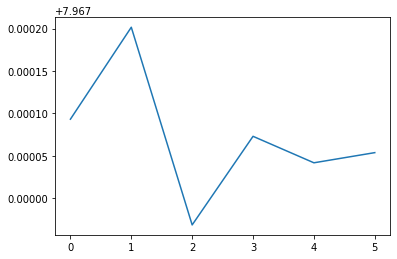

In [22]:
seaborn.lineplot(list(range(len(likelihoods))),likelihoods)

In [23]:
num=1.0*(Topic2TermCount )
beta=num.T/(num.sum(axis=0).reshape(n_topics, 1))
num=(Z + L)
theta=num / num.sum(axis=1).reshape(X.shape[0], 1)
theta=theta[new_cell_inds,:]

In [17]:
t0=time.process_time()
chosen=np.random.choice(list(range(X.shape[0])),size=100)
chosen2=np.random.choice(list(range(X.shape[1])),size=1000)
print(logLikelihood(beta[:,chosen2],theta[chosen,:],X[chosen,:][:,chosen2]))
t1=time.process_time()
t1-t0

7.81249846598161


3.7340922250000403

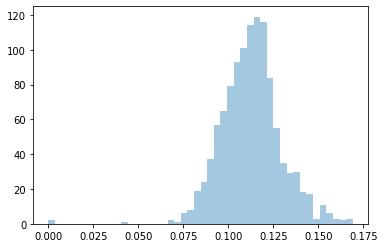

In [27]:
seaborn.distplot(theta[:,0],kde=False)

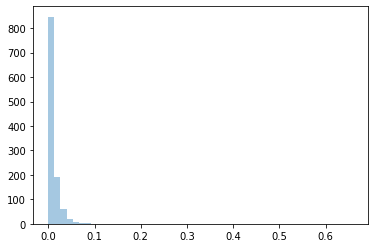

In [25]:
seaborn.distplot(theta[:,9],kde=False)

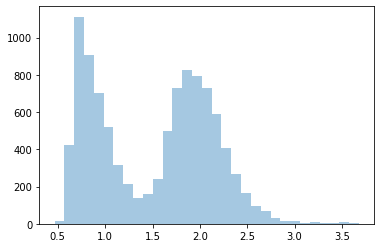

In [20]:
seaborn.distplot(ambient_pdf.resample(10000),kde=False)

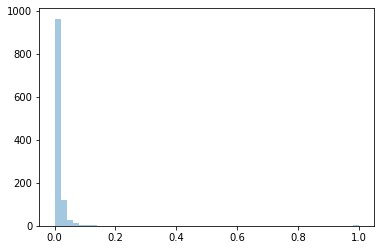

In [21]:
seaborn.distplot(theta[new_cell_inds,9],kde=False)

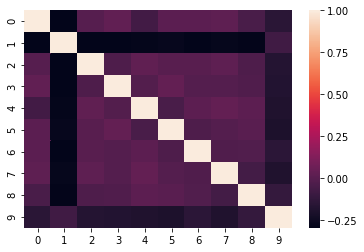

In [28]:
seaborn.heatmap(np.corrcoef(theta.T))

In [23]:
np.corrcoef(beta[9,:], betaAmbient)

array([[1.        , 0.99999654],
       [0.99999654, 1.        ]])

In [29]:
adata_copy=adata.copy()
adata._inplace_subset_obs(cell_inds)
adata

AnnData object with n_obs × n_vars = 1140 × 10092 
    obs: 'n_counts'
    var: 'gene_ids', 'n_cells'

In [30]:
sc.pp.normalize_total(adata, target_sum=1e4,)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)


/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/mt/code/utils/miniconda3/envs/pymc/lib/p

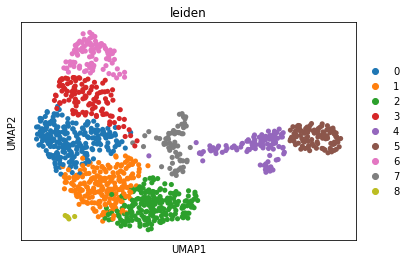

In [31]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])


In [32]:
for i in range(theta.shape[1]):
    adata.obs['lda_'+str(i)]=np.log(theta[new_cell_inds,i])


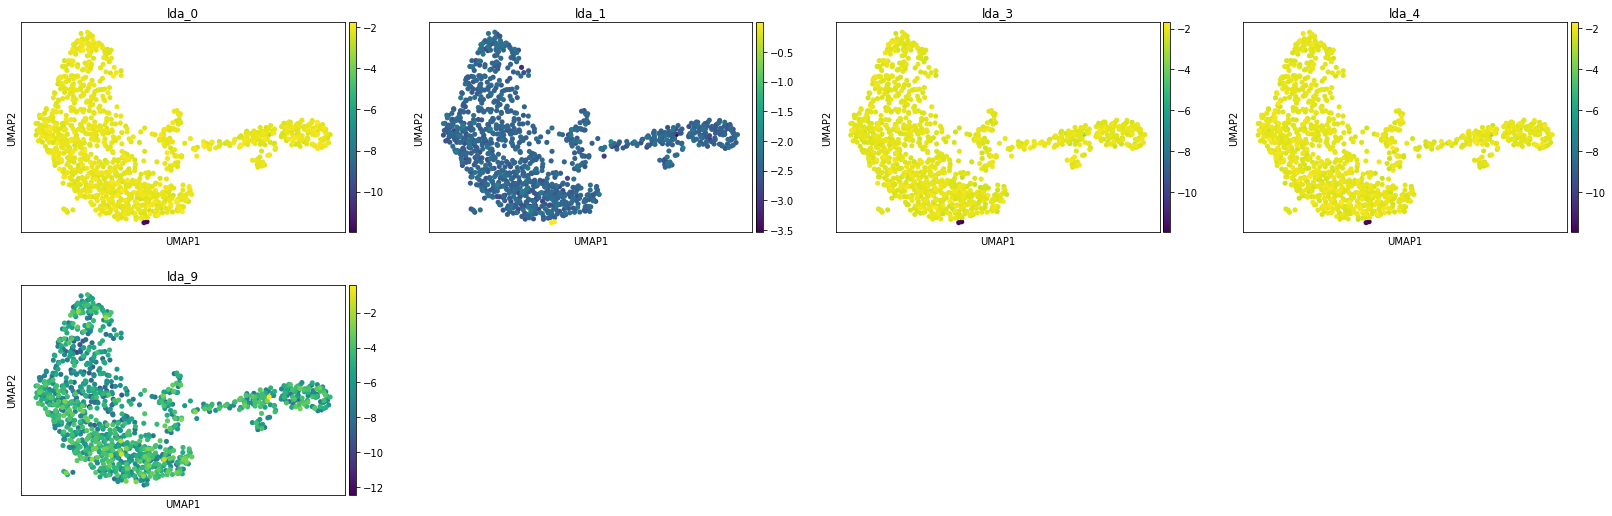

In [34]:
sc.pl.umap(adata, color=['lda_0','lda_1','lda_3','lda_4','lda_9'])


In [29]:
adata_copy._inplace_subset_obs(cell_inds)

In [30]:
print(Z[new_cell_inds,:].shape)
print(adata_copy.shape)
print(beta.shape)
print(theta.shape)


(1140, 10)
(1140, 10092)
(10, 10092)
(1140, 10)


In [31]:
t0=time.process_time()
vals=[]
pvals=[]
for i in range(adata_copy.shape[1]):
    vals=vals+[i for x in range(int(adata_copy.X[c,i]))]
    pvals=pvals+[beta[n_topics-1,i] for x in range(int(adata_copy.X[c,i]))]
t1=time.process_time()
print(t1-t0)


IndexError: invalid index

In [ ]:
t0=time.process_time()
vals=[]
pvals=[]
for i in range(adata_copy.shape[1]):
    vals=vals+[i]*int(adata_copy.X[c,i])
    pvals=pvals+[beta[n_topics-1,i]]*int(adata_copy.X[c,i])
t1=time.process_time()
print(t1-t0)


In [ ]:
for c in tqdm(range(adata_copy.shape[0])):
    vals=[]
    pvals=[]
    for i in range(adata_copy.shape[1]):
        vals=vals+[i]*int(adata_copy.X[c,i])
        pvals=pvals+[beta[n_topics-1,i]]*int(adata_copy.X[c,i])
    if len(vals)>0:
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(Z[c,n_topics-1])),p=pvals/sum(pvals))) 
        adata_copy.X[c,list(countremove.keys())]-=np.array(list(countremove.values()))


In [34]:
for i in range(theta.shape[1]):
    adata_copy.obs['lda_'+str(i)]=theta[new_cell_inds,i]

sc.pp.filter_genes(adata_copy,min_counts=1,inplace=True)
sc.pp.filter_cells(adata_copy,min_counts=100,inplace=True)
sc.pp.normalize_total(adata_copy, target_sum=1e4)
sc.pp.log1p(adata_copy)
sc.pp.highly_variable_genes(adata_copy,n_top_genes=5000,inplace=True)
sc.pp.scale(adata_copy, max_value=10)
sc.pp.pca(adata_copy)
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)


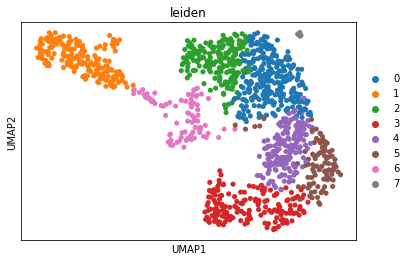

In [39]:
sc.tl.leiden(adata_copy)
sc.pl.umap(adata_copy, color=['leiden'])


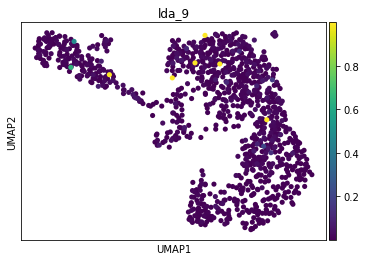

In [40]:
sc.pl.umap(adata_copy, color=['lda_9'])


In [62]:
c=Counter(np.random.choice(list(range(adata_copy.shape[1])),p=beta[9,:].A1,size=int(Z[0,9]))) 
Z[m,list(c.keys())]=list(c.values())


Counter({5062: 1,
         6107: 2,
         5889: 1,
         7387: 3,
         6263: 3,
         7122: 2,
         9240: 1,
         4922: 1,
         3302: 1,
         9529: 1,
         2762: 2,
         4298: 2,
         10094: 2,
         5545: 1,
         4804: 1,
         9848: 1,
         3503: 1,
         1683: 1,
         1572: 2,
         138: 1,
         693: 2,
         6773: 1,
         8733: 1,
         9921: 1,
         5186: 3,
         9518: 2,
         2716: 1,
         1732: 1,
         155: 5,
         2971: 1,
         375: 1,
         643: 1,
         7186: 1,
         5619: 1,
         940: 1,
         4512: 1,
         1363: 1,
         1574: 1,
         5338: 2,
         5431: 1,
         1636: 1,
         1453: 1,
         4564: 3,
         3530: 1,
         9321: 1,
         9771: 1,
         5061: 1,
         10011: 2,
         9723: 1,
         3250: 1,
         5377: 1,
         9786: 2,
         7235: 1,
         6950: 1,
         311: 1,
         6343: 

In [69]:
print(self.Doc2TopicCount)
print(self.Doc2TopicCount.shape)
print(self.Topic2TermCount)
print(self.Topic2TermCount.shape)
print(self.Topic2TermCountSum)

[[0 0 0 5 1 0]
 [6 0 0 0 1 3]
 [4 0 0 4 2 0]
 [0 9 0 0 2 0]
 [0 0 7 0 0 0]
 [0 0 0 0 5 0]]
(6, 6)
[[0 0 0 0 0 0 7 3 0 0]
 [0 0 0 6 0 0 0 0 0 3]
 [0 4 0 0 3 0 0 0 0 0]
 [9 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 5 0]
 [0 0 0 0 0 3 0 0 0 0]]
(6, 10)
[10  9  7  9 11  3]


In [139]:
Topic2TermCount=((X/X.sum(axis=1)).T * Z)
Topic2TermCountSum=Topic2TermCount.sum(axis=0).A1

In [91]:
m=1
doc_m_alpha_vector = alpha_vector_Lambda[m]
curdoc=X[m,:]

In [146]:
Doc2TopicCount[m,:].toarray()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 50.]])

In [159]:
Topic2TermCount

matrix([[  134.31984811,   134.35733303,   134.40464987, ...,
           134.49291377,   134.32893568,   864.06462749],
        [   72.37842259,    72.62154687,    72.60821777, ...,
            72.32418615,    72.31971275,   700.41539282],
        [   90.36737184,    90.59531053,    90.47990819, ...,
            90.30017399,    90.23734629,   481.38950528],
        ...,
        [  167.03071764,   167.2470855 ,   167.49114512, ...,
           167.21644238,   166.90353463,  1187.10145311],
        [ 7143.56015697,  7154.40697186,  7160.04115054, ...,
          7149.98631216,  7149.47205645, 48042.58269527],
        [   95.54083527,    95.38178684,    95.52360707, ...,
            95.68692422,    95.46662673,   586.80473395]])

In [189]:
(curdoc.T/curdoc.sum()*Z[m,:]).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
Zminus = Z-Z[m,:]
Topic2TermCount -= (curdoc.T/curdoc.sum()*Z[m,:])
Topic2TermCountSum -= Topic2TermCount.sum(axis=0).A1



In [163]:
numerator_theta_vector = Zminus[m,:] + L[m,:]
numerator_theta_vector

matrix([[9.99999991e-10, 9.99999991e-10, 9.99999991e-10, 9.99999991e-10,
         9.99999991e-10, 9.99999991e-10, 9.99999991e-10, 9.99999991e-10,
         9.99999991e-10, 5.10000000e+01]])

In [164]:
numerator_beta_vector = X[m,:]*Topic2TermCount + eta_vector
denominator_beta = Topic2TermCountSum + eta_vector_sum


In [165]:
denominator_beta

array([ 996266.00002847,  997408.00001017,  998241.00001456,
        997435.00001682,  996011.00001442,  995949.00002452,
        997678.00001382,  996792.00001105,  997224.00002712,
       7934873.02153697])

In [166]:
beta_vector = 1.0 * numerator_beta_vector / denominator_beta
beta_vector

matrix([[0.15158416, 0.15156713, 0.15163241, 0.15160118, 0.15160936,
         0.15159239, 0.15162051, 0.15159285, 0.15160618, 0.17236273]])

In [185]:
# theta_vector = 1.0 * numerator_theta_vector / denominator_theta
# denominator_theta is independent with t and k, so denominator could be any value except 0
# will set denominator_theta as 1.0
theta_vector = numerator_theta_vector

p_vector = np.multiply(beta_vector , theta_vector)
# print( p_vector)
p_vector = 1.0 * p_vector / np.sum(p_vector)
print( p_vector )


[1.72440898e-11 1.72421529e-11 1.72495782e-11 1.72460264e-11
 1.72469562e-11 1.72450260e-11 1.72482253e-11 1.72450788e-11
 1.72465952e-11 1.00000000e+00]


In [187]:
c=Counter(np.random.choice(list(range(n_topics)),p=p_vector.A1,size=int(np.sum(Z[m,:])))) 
Z[m,list(c.keys())]=list(c.values())

Counter({9: 50})

In [70]:
#Now going to reassign z for this word
k = z
self.Doc2TopicCount[m, k] -= 1
self.Topic2TermCount[k, t] -= 1
self.Topic2TermCountSum[k] -= 1


In [71]:
doc_m_alpha_vector

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

In order to move towards a more likely parameter set, need to use the following proportionality between the likelihood without the current terms label and 

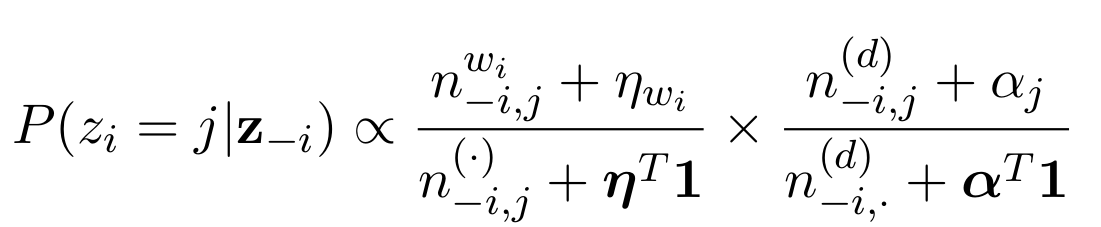

In [72]:
numerator_theta_vector = (self.Doc2TopicCount[m])*density(self.Doc2TopicCount[m][junkindex]) + doc_m_alpha_vector
print(self.Doc2TopicCount[m])
print(doc_m_alpha_vector)
print(numerator_theta_vector)

[5 0 0 0 1 3]
[0.2 0.2 0.2 0.2 0.2 0.2]
[0.2 0.2 0.2 0.2 0.2 0.2]


Is this, the number words in each topic for the document, plus the label including alpha prior:
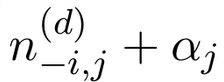

In [73]:
numerator_beta_vector = self.Topic2TermCount[:, t] + self.eta_vector[t]
print( self.Topic2TermCount[:, t])
print(self.eta_vector[t])

[2 0 0 0 0 0]
0.002


Is this, the number of times the term appears in each topic plus the prior eta:
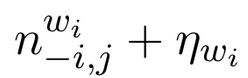

In [74]:
denominator_beta = self.Topic2TermCountSum + self.eta_vector_sum
print(self.Topic2TermCountSum )
print(self.eta_vector_sum)
beta_vector = 1.0 * numerator_beta_vector / denominator_beta


[ 9  9  7  9 11  3]
0.020000000000000004


In [87]:
ambientp=np.full((len(self.Topic2TermCountSum)),density(self.Topic2TermCountSum[junkindex]))
ambientp[junkindex]=density(self.Topic2TermCountSum[junkindex]+1)


In [88]:
ambientp

array([2.02187893e-084, 2.02187893e-084, 2.02187893e-084, 2.02187893e-084,
       2.02187893e-084, 6.51588006e-172])

Is this, the total number of terms in each topic plus the total beta (eta) prior
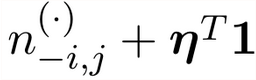

In [39]:
theta_vector = numerator_theta_vector/1

theta_vector = 1.0 * numerator_theta_vector / denominator_theta, but the denominator_theta is independent with t and k, so denominator could be any value except 0, so he sets denominator_theta as 1.0.
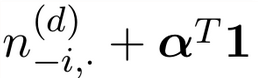

In [86]:
p_vector = beta_vector * theta_vector * ambientp
print( p_vector)
p_vector = 1.0 * p_vector / sum(p_vector)
print('Renormalized p_vector')
print( p_vector)

[8.97516990e-86 8.96620370e-89 1.84330843e-87 8.96620370e-89
 7.33894350e-89 5.84668265e-03]
Renormalized p_vector
[1.53508758e-83 1.53355402e-86 3.15274240e-85 1.53355402e-86
 1.25523206e-86 1.00000000e+00]


Now we use the Gibbs likelihood ratio to resample z. 

In [41]:
sample_z = self._multinomial_sample(p_vector)
print(sample_z)
self.Z[m][n] = sample_z
k = sample_z
self.Doc2TopicCount[m, k] += 1
self.Topic2TermCount[k, t] += 1
self.Topic2TermCountSum[k] += 1
count += 1
print(self.Doc2TopicCount)
print(self.Topic2TermCount)
print(self.Topic2TermCountSum[k])

5
[[5 0 0 0 1 0]
 [0 0 3 0 0 7]
 [4 0 4 0 1 1]
 [0 3 0 0 8 0]
 [0 0 0 7 0 0]
 [0 0 0 0 1 4]]
[[9 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3]
 [0 0 0 0 0 0 7 0 0 0]
 [0 4 0 0 3 0 0 0 0 0]
 [0 0 5 6 0 0 0 0 0 0]
 [0 0 1 0 0 3 0 3 5 0]]
12


Simply doing multiple passes through the data allows convergence on a MAP configuration of the model parameters. Doing inference on a new, unlabeled document 

In [156]:
import numpy as np
term_vector=[2,1,0,3,2,2,2,2,2,2,2,2,2,2,2]
iteration=30

doc_topic_count = np.zeros(self.K, dtype=int)
p_vector = np.ones(self.K, dtype=int)
p_vector = p_vector * 1.0 / sum(p_vector)
z_vector = [self._multinomial_sample(p_vector) for _ in term_vector]
for n, t in enumerate(term_vector):
    k = z_vector[n]
    doc_topic_count[k] += 1
    self.Topic2TermCount[k, t] += 1
    self.Topic2TermCountSum[k] += 1

# sum_doc_topic_count = sum(doc_topic_count)
doc_m_alpha_vector = self.alpha_vector
# sum_doc_m_alpha_vector = sum(doc_m_alpha_vector)
for i in range(iteration):
    for n, t in enumerate(term_vector):
        k = z_vector[n]
        doc_topic_count[k] -= 1
        self.Topic2TermCount[k, t] -= 1
        self.Topic2TermCountSum[k] -= 1

        numerator_theta_vector = doc_topic_count + doc_m_alpha_vector
        # denominator_theta = sum_doc_topic_count - 1 + sum_doc_m_alpha_vector

        numerator_beta_vector = self.Topic2TermCount[:, t] + self.eta_vector[t]
        # denominator_beta = self.Topic2TermCount.sum(axis=1) + sum(self.eta_vector)
        denominator_beta = self.Topic2TermCountSum + self.eta_vector_sum

        beta_vector = 1.0 * numerator_beta_vector / denominator_beta
        # theta_vector = 1.0 numerator_theta_vector / denominator_theta
        # denominator_theta is independent with t and k, so denominator could be any value except 0
        # will set denominator_theta as 1.0
        theta_vector = numerator_theta_vector

        p_vector = beta_vector * theta_vector
        # print( p_vector)
        p_vector = 1.0 * p_vector / sum(p_vector)
        # print( p_vector)
        sample_z = self._multinomial_sample(p_vector)
        z_vector[n] = sample_z

        k = sample_z
        doc_topic_count[k] += 1
        self.Topic2TermCount[k, t] += 1
        self.Topic2TermCountSum[k] += 1
# reset self.Topic2TermCount
for n, t in enumerate(term_vector):
    k = z_vector[n]
    self.Topic2TermCount[k, t] -= 1
    self.Topic2TermCountSum[k] -= 1

numerator_theta_vector = doc_topic_count + doc_m_alpha_vector
# denominator_theta = sum(doc_topic_count) + sum(doc_m_alpha_vector)
denominator_theta = sum(numerator_theta_vector)
theta_new = 1.0 * numerator_theta_vector / denominator_theta


In [159]:
z_vector

[2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2]

In [158]:
#the mixture of the new document
theta_new

array([0.19973545, 0.00132275, 0.79497354, 0.00132275, 0.00132275,
       0.00132275])

In [ ]:
onlineldavb/onlineldavb.py
@chelseaz chelseaz get example to work 68de1f8 on Nov 19, 2015
@chelseaz
@matthewdhoffman
476 lines (407 sloc) 18.7 KB
# onlineldavb.py: Package of functions for fitting Latent Dirichlet
# Allocation (LDA) with online variational Bayes (VB).
#
# Copyright (C) 2010  Matthew D. Hoffman
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

import sys, re, time, string
import numpy as n
from scipy.special import gammaln, psi

import corpus

n.random.seed(100000001)
meanchangethresh = 0.001

def dirichlet_expectation(alpha):
    """
    For a vector theta ~ Dir(alpha), computes E[log(theta)] given alpha.
    """
    if (len(alpha.shape) == 1):
        return(psi(alpha) - psi(n.sum(alpha)))
    return(psi(alpha) - psi(n.sum(alpha, 1))[:, n.newaxis])

def parse_doc_list(docs, vocab):
    """
    Parse a document into a list of word ids and a list of counts,
    or parse a set of documents into two lists of lists of word ids
    and counts.
    Arguments: 
    docs:  List of D documents. Each document must be represented as
           a single string. (Word order is unimportant.) Any
           words not in the vocabulary will be ignored.
    vocab: Dictionary mapping from words to integer ids.
    Returns a pair of lists of lists. 
    The first, wordids, says what vocabulary tokens are present in
    each document. wordids[i][j] gives the jth unique token present in
    document i. (Don't count on these tokens being in any particular
    order.)
    The second, wordcts, says how many times each vocabulary token is
    present. wordcts[i][j] is the number of times that the token given
    by wordids[i][j] appears in document i.
    """
    if (type(docs).__name__ == 'str'):
        temp = list()
        temp.append(docs)
        docs = temp

    D = len(docs)
    
    wordids = list()
    wordcts = list()
    for d in range(0, D):
        docs[d] = docs[d].lower()
        docs[d] = re.sub(r'-', ' ', docs[d])
        docs[d] = re.sub(r'[^a-z ]', '', docs[d])
        docs[d] = re.sub(r' +', ' ', docs[d])
        words = string.split(docs[d])
        ddict = dict()
        for word in words:
            if (word in vocab):
                wordtoken = vocab[word]
                if (not wordtoken in ddict):
                    ddict[wordtoken] = 0
                ddict[wordtoken] += 1
        wordids.append(ddict.keys())
        wordcts.append(ddict.values())

    return((wordids, wordcts))

class OnlineLDA:
    """
    Implements online VB for LDA as described in (Hoffman et al. 2010).
    """

    def __init__(self, vocab, K, D, alpha, eta, tau0, kappa):
        """
        Arguments:
        K: Number of topics
        vocab: A set of words to recognize. When analyzing documents, any word
           not in this set will be ignored.
        D: Total number of documents in the population. For a fixed corpus,
           this is the size of the corpus. In the truly online setting, this
           can be an estimate of the maximum number of documents that
           could ever be seen.
        alpha: Hyperparameter for prior on weight vectors theta
        eta: Hyperparameter for prior on topics beta
        tau0: A (positive) learning parameter that downweights early iterations
        kappa: Learning rate: exponential decay rate---should be between
             (0.5, 1.0] to guarantee asymptotic convergence.
        Note that if you pass the same set of D documents in every time and
        set kappa=0 this class can also be used to do batch VB.
        """
        self._vocab = dict()
        for word in vocab:
            word = word.lower()
            word = re.sub(r'[^a-z]', '', word)
            self._vocab[word] = len(self._vocab)

        self._K = K
        self._W = len(self._vocab)
        self._D = D
        self._alpha = alpha
        self._eta = eta
        self._tau0 = tau0 + 1
        self._kappa = kappa
        self._updatect = 0

        # Initialize the variational distribution q(beta|lambda)
        self._lambda = 1*n.random.gamma(100., 1./100., (self._K, self._W))
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)

    def do_e_step(self, wordids, wordcts):
        batchD = len(wordids)

        # Initialize the variational distribution q(theta|gamma) for
        # the mini-batch
        gamma = 1*n.random.gamma(100., 1./100., (batchD, self._K))
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = n.exp(Elogtheta)

        sstats = n.zeros(self._lambda.shape)
        # Now, for each document d update that document's gamma and phi
        it = 0
        meanchange = 0
        for d in range(0, batchD):
            print sum(wordcts[d])
            # These are mostly just shorthand (but might help cache locality)
            ids = wordids[d]
            cts = wordcts[d]
            gammad = gamma[d, :]
            Elogthetad = Elogtheta[d, :]
            expElogthetad = expElogtheta[d, :]
            expElogbetad = self._expElogbeta[:, ids]
            # The optimal phi_{dwk} is proportional to 
            # expElogthetad_k * expElogbetad_w. phinorm is the normalizer.
            phinorm = n.dot(expElogthetad, expElogbetad) + 1e-100
            # Iterate between gamma and phi until convergence
            for it in range(0, 100):
                lastgamma = gammad
                # We represent phi implicitly to save memory and time.
                # Substituting the value of the optimal phi back into
                # the update for gamma gives this update. Cf. Lee&Seung 2001.
                gammad = self._alpha + expElogthetad * \
                    n.dot(cts / phinorm, expElogbetad.T)
                print gammad[:, n.newaxis]
                Elogthetad = dirichlet_expectation(gammad)
                expElogthetad = n.exp(Elogthetad)
                phinorm = n.dot(expElogthetad, expElogbetad) + 1e-100
                # If gamma hasn't changed much, we're done.
                meanchange = n.mean(abs(gammad - lastgamma))
                if (meanchange < meanchangethresh):
                    break
            gamma[d, :] = gammad
            # Contribution of document d to the expected sufficient
            # statistics for the M step.
            sstats[:, ids] += n.outer(expElogthetad.T, cts/phinorm)

        # This step finishes computing the sufficient statistics for the
        # M step, so that
        # sstats[k, w] = \sum_d n_{dw} * phi_{dwk} 
        # = \sum_d n_{dw} * exp{Elogtheta_{dk} + Elogbeta_{kw}} / phinorm_{dw}.
        sstats = sstats * self._expElogbeta

        return((gamma, sstats))

    def do_e_step_docs(self, docs):
        """
        Given a mini-batch of documents, estimates the parameters
        gamma controlling the variational distribution over the topic
        weights for each document in the mini-batch.
        Arguments:
        docs:  List of D documents. Each document must be represented
               as a string. (Word order is unimportant.) Any
               words not in the vocabulary will be ignored.
        Returns a tuple containing the estimated values of gamma,
        as well as sufficient statistics needed to update lambda.
        """
        # This is to handle the case where someone just hands us a single
        # document, not in a list.
        if (type(docs).__name__ == 'string'):
            temp = list()
            temp.append(docs)
            docs = temp

        (wordids, wordcts) = parse_doc_list(docs, self._vocab)

        return self.do_e_step(wordids, wordcts)
    
#         batchD = len(docs)

#         # Initialize the variational distribution q(theta|gamma) for
#         # the mini-batch
#         gamma = 1*n.random.gamma(100., 1./100., (batchD, self._K))
#         Elogtheta = dirichlet_expectation(gamma)
#         expElogtheta = n.exp(Elogtheta)

#         sstats = n.zeros(self._lambda.shape)
#         # Now, for each document d update that document's gamma and phi
#         it = 0
#         meanchange = 0
#         for d in range(0, batchD):
#             # These are mostly just shorthand (but might help cache locality)
#             ids = wordids[d]
#             cts = wordcts[d]
#             gammad = gamma[d, :]
#             Elogthetad = Elogtheta[d, :]
#             expElogthetad = expElogtheta[d, :]
#             expElogbetad = self._expElogbeta[:, ids]
#             # The optimal phi_{dwk} is proportional to 
#             # expElogthetad_k * expElogbetad_w. phinorm is the normalizer.
#             phinorm = n.dot(expElogthetad, expElogbetad) + 1e-100
#             # Iterate between gamma and phi until convergence
#             for it in range(0, 100):
#                 lastgamma = gammad
#                 # We represent phi implicitly to save memory and time.
#                 # Substituting the value of the optimal phi back into
#                 # the update for gamma gives this update. Cf. Lee&Seung 2001.
#                 gammad = self._alpha + expElogthetad * \
#                     n.dot(cts / phinorm, expElogbetad.T)
#                 Elogthetad = dirichlet_expectation(gammad)
#                 expElogthetad = n.exp(Elogthetad)
#                 phinorm = n.dot(expElogthetad, expElogbetad) + 1e-100
#                 # If gamma hasn't changed much, we're done.
#                 meanchange = n.mean(abs(gammad - lastgamma))
#                 if (meanchange < meanchangethresh):
#                     break
#             gamma[d, :] = gammad
#             # Contribution of document d to the expected sufficient
#             # statistics for the M step.
#             sstats[:, ids] += n.outer(expElogthetad.T, cts/phinorm)

#         # This step finishes computing the sufficient statistics for the
#         # M step, so that
#         # sstats[k, w] = \sum_d n_{dw} * phi_{dwk} 
#         # = \sum_d n_{dw} * exp{Elogtheta_{dk} + Elogbeta_{kw}} / phinorm_{dw}.
#         sstats = sstats * self._expElogbeta

#         return((gamma, sstats))

    def update_lambda_docs(self, docs):
        """
        First does an E step on the mini-batch given in wordids and
        wordcts, then uses the result of that E step to update the
        variational parameter matrix lambda.
        Arguments:
        docs:  List of D documents. Each document must be represented
               as a string. (Word order is unimportant.) Any
               words not in the vocabulary will be ignored.
        Returns gamma, the parameters to the variational distribution
        over the topic weights theta for the documents analyzed in this
        update.
        Also returns an estimate of the variational bound for the
        entire corpus for the OLD setting of lambda based on the
        documents passed in. This can be used as a (possibly very
        noisy) estimate of held-out likelihood.
        """

        # rhot will be between 0 and 1, and says how much to weight
        # the information we got from this mini-batch.
        rhot = pow(self._tau0 + self._updatect, -self._kappa)
        self._rhot = rhot
        # Do an E step to update gamma, phi | lambda for this
        # mini-batch. This also returns the information about phi that
        # we need to update lambda.
        (gamma, sstats) = self.do_e_step_docs(docs)
        # Estimate held-out likelihood for current values of lambda.
        bound = self.approx_bound_docs(docs, gamma)
        # Update lambda based on documents.
        self._lambda = self._lambda * (1-rhot) + \
            rhot * (self._eta + self._D * sstats / len(docs))
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)
        self._updatect += 1

        return(gamma, bound)

    def update_lambda(self, wordids, wordcts):
        """
        First does an E step on the mini-batch given in wordids and
        wordcts, then uses the result of that E step to update the
        variational parameter matrix lambda.
        Arguments:
        docs:  List of D documents. Each document must be represented
               as a string. (Word order is unimportant.) Any
               words not in the vocabulary will be ignored.
        Returns gamma, the parameters to the variational distribution
        over the topic weights theta for the documents analyzed in this
        update.
        Also returns an estimate of the variational bound for the
        entire corpus for the OLD setting of lambda based on the
        documents passed in. This can be used as a (possibly very
        noisy) estimate of held-out likelihood.
        """

        # rhot will be between 0 and 1, and says how much to weight
        # the information we got from this mini-batch.
        rhot = pow(self._tau0 + self._updatect, -self._kappa)
        self._rhot = rhot
        # Do an E step to update gamma, phi | lambda for this
        # mini-batch. This also returns the information about phi that
        # we need to update lambda.
        (gamma, sstats) = self.do_e_step(wordids, wordcts)
        # Estimate held-out likelihood for current values of lambda.
        bound = self.approx_bound(wordids, wordcts, gamma)
        # Update lambda based on documents.
        self._lambda = self._lambda * (1-rhot) + \
            rhot * (self._eta + self._D * sstats / len(wordids))
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)
        self._updatect += 1

        return(gamma, bound)

    def approx_bound(self, wordids, wordcts, gamma):
        """
        Estimates the variational bound over *all documents* using only
        the documents passed in as "docs." gamma is the set of parameters
        to the variational distribution q(theta) corresponding to the
        set of documents passed in.
        The output of this function is going to be noisy, but can be
        useful for assessing convergence.
        """

        # This is to handle the case where someone just hands us a single
        # document, not in a list.
        batchD = len(wordids)

        score = 0
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = n.exp(Elogtheta)

        # E[log p(docs | theta, beta)]
        for d in range(0, batchD):
            gammad = gamma[d, :]
            ids = wordids[d]
            cts = n.array(wordcts[d])
            phinorm = n.zeros(len(ids))
            for i in range(0, len(ids)):
                temp = Elogtheta[d, :] + self._Elogbeta[:, ids[i]]
                tmax = max(temp)
                phinorm[i] = n.log(sum(n.exp(temp - tmax))) + tmax
            score += n.sum(cts * phinorm)
#             oldphinorm = phinorm
#             phinorm = n.dot(expElogtheta[d, :], self._expElogbeta[:, ids])
#             print oldphinorm
#             print n.log(phinorm)
#             score += n.sum(cts * n.log(phinorm))

        # E[log p(theta | alpha) - log q(theta | gamma)]
        score += n.sum((self._alpha - gamma)*Elogtheta)
        score += n.sum(gammaln(gamma) - gammaln(self._alpha))
        score += sum(gammaln(self._alpha*self._K) - gammaln(n.sum(gamma, 1)))

        # Compensate for the subsampling of the population of documents
        score = score * self._D / len(wordids)

        # E[log p(beta | eta) - log q (beta | lambda)]
        score = score + n.sum((self._eta-self._lambda)*self._Elogbeta)
        score = score + n.sum(gammaln(self._lambda) - gammaln(self._eta))
        score = score + n.sum(gammaln(self._eta*self._W) - 
                              gammaln(n.sum(self._lambda, 1)))

        return(score)

    def approx_bound_docs(self, docs, gamma):
        """
        Estimates the variational bound over *all documents* using only
        the documents passed in as "docs." gamma is the set of parameters
        to the variational distribution q(theta) corresponding to the
        set of documents passed in.
        The output of this function is going to be noisy, but can be
        useful for assessing convergence.
        """

        # This is to handle the case where someone just hands us a single
        # document, not in a list.
        if (type(docs).__name__ == 'string'):
            temp = list()
            temp.append(docs)
            docs = temp

        (wordids, wordcts) = parse_doc_list(docs, self._vocab)
        batchD = len(docs)

        score = 0
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = n.exp(Elogtheta)

        # E[log p(docs | theta, beta)]
        for d in range(0, batchD):
            gammad = gamma[d, :]
            ids = wordids[d]
            cts = n.array(wordcts[d])
            phinorm = n.zeros(len(ids))
            for i in range(0, len(ids)):
                temp = Elogtheta[d, :] + self._Elogbeta[:, ids[i]]
                tmax = max(temp)
                phinorm[i] = n.log(sum(n.exp(temp - tmax))) + tmax
            score += n.sum(cts * phinorm)
#             oldphinorm = phinorm
#             phinorm = n.dot(expElogtheta[d, :], self._expElogbeta[:, ids])
#             print oldphinorm
#             print n.log(phinorm)
#             score += n.sum(cts * n.log(phinorm))

        # E[log p(theta | alpha) - log q(theta | gamma)]
        score += n.sum((self._alpha - gamma)*Elogtheta)
        score += n.sum(gammaln(gamma) - gammaln(self._alpha))
        score += sum(gammaln(self._alpha*self._K) - gammaln(n.sum(gamma, 1)))

        # Compensate for the subsampling of the population of documents
        score = score * self._D / len(docs)

        # E[log p(beta | eta) - log q (beta | lambda)]
        score = score + n.sum((self._eta-self._lambda)*self._Elogbeta)
        score = score + n.sum(gammaln(self._lambda) - gammaln(self._eta))
        score = score + n.sum(gammaln(self._eta*self._W) - 
                              gammaln(n.sum(self._lambda, 1)))

        return(score)

def main():
    infile = sys.argv[1]
    K = int(sys.argv[2])
    alpha = float(sys.argv[3])
    eta = float(sys.argv[4])
    kappa = float(sys.argv[5])
    S = int(sys.argv[6])

    docs = corpus.corpus()
    docs.read_data(infile)

    vocab = open(sys.argv[7]).readlines()
    model = OnlineLDA(vocab, K, 100000,
                      0.1, 0.01, 1, 0.75)
    for i in range(1000):
        print i
        wordids = [d.words for d in docs.docs[(i*S):((i+1)*S)]]
        wordcts = [d.counts for d in docs.docs[(i*S):((i+1)*S)]]
        model.update_lambda(wordids, wordcts)
        n.savetxt('/tmp/lambda%d' % i, model._lambda.T)
    
#     infile = open(infile)
#     corpus.read_stream_data(infile, 100000)

if __name__ == '__main__':
    main()
